In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

Input: geriatric falls dataset with health statuses labels, cleaned and with engineered data

Output: Label health status of participants

# Labelled set

In [25]:
# Load renamed ADL falls dataset
labeled_df = pd.read_csv("./ADLfalls_renamed_relabelledHealth_limitedActivities_trimmed.csv")


In [26]:
print(labeled_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   activity_label                  816 non-null    object 
 1   acceleration_x_mean             816 non-null    float64
 2   acceleration_y_mean             816 non-null    float64
 3   acceleration_z_mean             816 non-null    float64
 4   acceleration_diff_x_mean        816 non-null    float64
 5   acceleration_diff_z_mean        816 non-null    float64
 6   user_acceleration_x_mean        816 non-null    float64
 7   user_acceleration_y_mean        816 non-null    float64
 8   user_acceleration_y_std         816 non-null    float64
 9   user_acceleration_z_mean        816 non-null    float64
 10  user_acceleration_z_std         816 non-null    float64
 11  user_acceleration_diff_x_mean   816 non-null    float64
 12  user_acceleration_diff_x_std    816 

In [27]:
print(labeled_df['activity_label'].unique())

['Eat' 'Exercise' 'Fall' 'Sleep']


## Pipeline and training on labelled set

In [28]:
# labeled_df = labeled_df.drop(columns=['user_id'])
# labeled_df = labeled_df.drop(columns=['age_group','health_status'])

### Imputation by activity_label

In [29]:
# Detecting missing values
missing_list = list(labeled_df.columns[labeled_df.isna().any()])       

# Percentage of missing values
row_count = labeled_df.shape[0] 
# Create list of dicts (one per column)
data = []
for col in missing_list:
    count = labeled_df[col].isnull().sum()
    percent = (count / row_count) * 100
    data.append({
        'Columns with missing values': col,
        'Missing count': count,
        'Missing %': percent,
        'DataType' : labeled_df[col].dtype
    })

# Create DataFrame from list of dicts
missing_df = pd.DataFrame(data)
print(missing_df)

  Columns with missing values  Missing count  Missing % DataType
0            heart_rate_x_std              9   1.102941  float64
1       heart_rate_diff_x_std              9   1.102941  float64


In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

'''
Custom imputer class:
To impute the missing data by the mean values of the same activity.
'''
class GroupImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_cols, target_cols, strategy='mean'): # mean for numerical data
        self.group_cols = group_cols
        self.target_cols = target_cols
        self.strategy = strategy
        self.impute_values_ = None

    def fit(self, X, y=None):
        print("Fitting group imputer.")

        # If no target_cols passed, infer them
        if self.target_cols is None:
            self.target_cols = [
                col for col in X.columns
                if col not in self.group_cols and pd.api.types.is_numeric_dtype(X[col])
            ]
            
        self.impute_values_ = (
            X.groupby(self.group_cols)[self.target_cols]
              .agg(self.strategy)
              .reset_index()
        )
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.target_cols:
            merged = X_copy[self.group_cols].merge(
                self.impute_values_[[*self.group_cols, col]],
                on=self.group_cols,
                how="left"
            )[col]
            # First fill with group mean
            X_copy[col] = X_copy[col].fillna(merged)
            # Then fallback to global mean if still NaN
            if X_copy[col].isna().any():
                X_copy[col] = X_copy[col].fillna(X_copy[col].mean())
        return X_copy
    
    def get_feature_names_out(self, input_features=None):
        return input_features


In [31]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


# Nominal features to be one-hot encoded
nominal_cols_encode = ['activity_label','age_group']

# Numerical features to be imputed and scaled
numerical_cols_impute_scale = ['heart_rate_x_std', 'heart_rate_diff_x_std']
numerical_cols_scale = labeled_df.select_dtypes(include='number').drop(columns=numerical_cols_impute_scale).columns.tolist()

nominal_onehot_pipe = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_impute_scale_pipe = Pipeline([
    ("group_imputer", GroupImputer(
        group_cols=["activity_label"],   # grouping columns
        target_cols=None,  # columns to impute - impute all
        strategy="mean"   # strategy: mean for numeric
    )),
    ("drop_activity_label", FunctionTransformer(lambda df: df.drop(columns=["activity_label"]), validate=False)),
    ('scaler', StandardScaler())
    
])

numerical_scale_pipe = Pipeline([
    ('scaler', StandardScaler())
    
])

# print(nominal_cols_encode)
print(numerical_cols_impute_scale)
print(numerical_cols_scale)
print(len(nominal_cols_encode)+len(numerical_cols_impute_scale)+len(numerical_cols_scale))

['heart_rate_x_std', 'heart_rate_diff_x_std']
['acceleration_x_mean', 'acceleration_y_mean', 'acceleration_z_mean', 'acceleration_diff_x_mean', 'acceleration_diff_z_mean', 'user_acceleration_x_mean', 'user_acceleration_y_mean', 'user_acceleration_y_std', 'user_acceleration_z_mean', 'user_acceleration_z_std', 'user_acceleration_diff_x_mean', 'user_acceleration_diff_x_std', 'user_acceleration_diff_y_mean', 'user_acceleration_diff_y_std', 'user_acceleration_diff_z_mean', 'user_acceleration_diff_z_std', 'user_acceleration_vec_sum_mean', 'user_acceleration_vec_sum_std', 'rotation_rate_x_mean', 'rotation_rate_y_mean', 'rotation_rate_z_mean', 'rotation_rate_diff_x_std', 'rotation_rate_diff_y_std', 'rotation_rate_diff_z_std', 'rotation_rate_vec_sum_mean', 'rotation_rate_vec_sum_std', 'heart_rate_x_mean', 'magnetometer_x_mean', 'magnetometer_x_std', 'magnetometer_y_mean', 'magnetometer_y_std', 'magnetometer_z_mean', 'magnetometer_z_std', 'magnetometer_diff_x_std', 'magnetometer_diff_y_mean', 'm

In [32]:
# Check the distribution of the target column
print(labeled_df['health_status'].value_counts())
print(labeled_df['activity_label'].value_counts())

health_status
Healthy      636
Unhealthy    180
Name: count, dtype: int64
activity_label
Exercise    328
Fall        242
Sleep       164
Eat          82
Name: count, dtype: int64


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

X = labeled_df.drop(columns=['health_status'])
y = labeled_df['health_status']

# -----------------
# Balanced data:
# -----------------
# Split the data into training and test sets, ensuring stratification
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# y_train = y_train.map({'Healthy': 0, 'Unhealthy': 1})
# y_test = y_test.map({'Healthy': 0, 'Unhealthy': 1})

# -----------------
# Imbalanced data:
# -----------------
# Split the data into training and test sets, ensuring stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split the test-validation set (20%) into validation (10%) and test (10%) sets
# X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, random_state=42, stratify=y_testval)

y_train = y_train.map({'Healthy': 0, 'Unhealthy': 1})
# y_val = y_val.map({'Healthy': 0, 'Unhealthy': 1})
y_test = y_test.map({'Healthy': 0, 'Unhealthy': 1})

# Combine training features and target for resampling
train_df = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes in the training set only
train_majority = train_df[train_df.health_status == 0]
train_minority = train_df[train_df.health_status == 1]

len_maj = len(train_majority)
print(len_maj)
len_min = len(train_minority)
print(len_min)
n_samples_each = round((len_maj+len_min)/2)
print(n_samples_each)

# Upsample minority class in the training set
train_minority_upsampled = resample(train_minority, 
                                    replace=True,    # sample with replacement
                                    n_samples=n_samples_each,  # number of samples in upsampled minority class (reduced due to resource constraints)
                                    random_state=42) # reproducible results

# Downsample majority class in the training set
train_majority_downsampled = resample(train_majority, 
                                      replace=False,    # sample without replacement
                                      n_samples=n_samples_each,   # number of samples in downsampled majority class (reduced due to resource constraints)
                                      random_state=42)  # reproducible results

# Combine upsampled minority class with downsampled majority class
train_combined = pd.concat([train_majority_downsampled, train_minority_upsampled])

# Shuffle and reset index
train_combined = train_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Re-separate the features and target in the combined training set
X_train = train_combined.drop(columns='health_status')
y_train = train_combined['health_status']

print(y_test.value_counts())
print(y_train.value_counts())
print(X_train.info())

508
144
326
health_status
0    128
1     36
Name: count, dtype: int64
health_status
1    326
0    326
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652 entries, 0 to 651
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   activity_label                  652 non-null    object 
 1   acceleration_x_mean             652 non-null    float64
 2   acceleration_y_mean             652 non-null    float64
 3   acceleration_z_mean             652 non-null    float64
 4   acceleration_diff_x_mean        652 non-null    float64
 5   acceleration_diff_z_mean        652 non-null    float64
 6   user_acceleration_x_mean        652 non-null    float64
 7   user_acceleration_y_mean        652 non-null    float64
 8   user_acceleration_y_std         652 non-null    float64
 9   user_acceleration_z_mean        652 non-null    float64
 10  user_acceleration_z_std       

In [34]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('nominal_encode', nominal_onehot_pipe, nominal_cols_encode),
        ('num_impute_scale', numerical_impute_scale_pipe, numerical_cols_impute_scale + ['activity_label']),
        ('num_scale', numerical_scale_pipe, numerical_cols_scale)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    n_jobs=-1
    )


### Logistic Regression baseline

In [35]:
from sklearn.linear_model  import LogisticRegression

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42))
])


clf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nominal_encode', ...), ('num_impute_scale', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [36]:
from sklearn.metrics import accuracy_score, f1_score

y_train_pred = clf.predict(X_train)
y_train_pred_proba = clf.predict_proba(X_train)[:, 1]

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report

accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
roc_auc = roc_auc_score(y_train, y_train_pred_proba)
report = classification_report(y_train, y_train_pred)

print(f'Train Accuracy: {accuracy}\n')
print(f'Train Precision: {precision}\n')
print(f'Train Test Recall: {recall}\n')
print(f'Train F1 score: {f1}\n')
print(f'Train roc_auc: {roc_auc}\n')
print(f'Train report: {report}\n')


Train Accuracy: 0.6947852760736196

Train Precision: 0.6862170087976539

Train Test Recall: 0.7177914110429447

Train F1 score: 0.7016491754122939

Train roc_auc: 0.7614701343671195

Train report:               precision    recall  f1-score   support

           0       0.70      0.67      0.69       326
           1       0.69      0.72      0.70       326

    accuracy                           0.69       652
   macro avg       0.70      0.69      0.69       652
weighted avg       0.70      0.69      0.69       652




In [37]:
# predict on logistic regression
y_test_pred = clf.predict(X_test)
y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)
report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {accuracy}\n')
print(f'Test Precision: {precision}\n')
print(f'Test Test Recall: {recall}\n')
print(f'Test F1 score: {f1}\n')
print(f'Test roc_auc: {roc_auc}\n')
print(f'Test report: {report}\n')

Test Accuracy: 0.5609756097560976

Test Precision: 0.25

Test Test Recall: 0.5

Test F1 score: 0.3333333333333333

Test roc_auc: 0.5798611111111112

Test report:               precision    recall  f1-score   support

           0       0.80      0.58      0.67       128
           1       0.25      0.50      0.33        36

    accuracy                           0.56       164
   macro avg       0.53      0.54      0.50       164
weighted avg       0.68      0.56      0.60       164




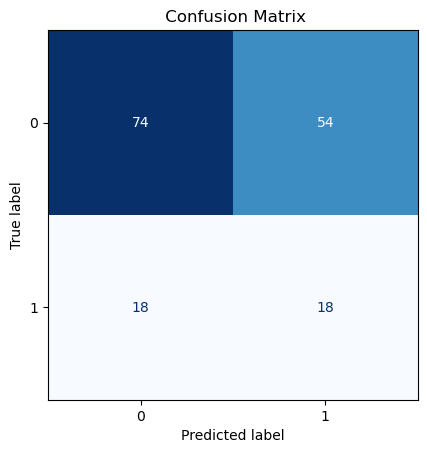

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
plt.title(" Confusion Matrix")
plt.grid(False)
plt.show()

### Random forest baseline

In [39]:
from sklearn.ensemble import RandomForestClassifier

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,        # more trees = smoother averaging
        max_depth=10,           # limit depth to avoid memorization
        min_samples_leaf=5,     # each leaf must have ≥ 5 samples
        max_features="sqrt",    # fewer features per split
        class_weight="balanced",# handle imbalance
        random_state=42
    ))
])


clf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nominal_encode', ...), ('num_impute_scale', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [40]:
from sklearn.metrics import accuracy_score, f1_score

y_train_pred = clf.predict(X_train)
y_train_pred_proba = clf.predict_proba(X_train)[:, 1]

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report

accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
roc_auc = roc_auc_score(y_train, y_train_pred_proba)
report = classification_report(y_train, y_train_pred)

print(f'Train Accuracy: {accuracy}\n')
print(f'Train Precision: {precision}\n')
print(f'Train Test Recall: {recall}\n')
print(f'Train F1 score: {f1}\n')
print(f'Train roc_auc: {roc_auc}\n')
print(f'Train report: {report}\n')



Train Accuracy: 0.9938650306748467

Train Precision: 0.9969135802469136

Train Test Recall: 0.99079754601227

Train F1 score: 0.9938461538461538

Train roc_auc: 0.9999247243027589

Train report:               precision    recall  f1-score   support

           0       0.99      1.00      0.99       326
           1       1.00      0.99      0.99       326

    accuracy                           0.99       652
   macro avg       0.99      0.99      0.99       652
weighted avg       0.99      0.99      0.99       652




In [41]:
# predict on random forest
y_test_pred = clf.predict(X_test)
y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)
report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {accuracy}\n')
print(f'Test Precision: {precision}\n')
print(f'Test Test Recall: {recall}\n')
print(f'Test F1 score: {f1}\n')
print(f'Test roc_auc: {roc_auc}\n')
print(f'Test report: {report}\n')

Test Accuracy: 0.7073170731707317

Test Precision: 0.2692307692307692

Test Test Recall: 0.19444444444444445

Test F1 score: 0.22580645161290322

Test roc_auc: 0.5475260416666666

Test report:               precision    recall  f1-score   support

           0       0.79      0.85      0.82       128
           1       0.27      0.19      0.23        36

    accuracy                           0.71       164
   macro avg       0.53      0.52      0.52       164
weighted avg       0.68      0.71      0.69       164




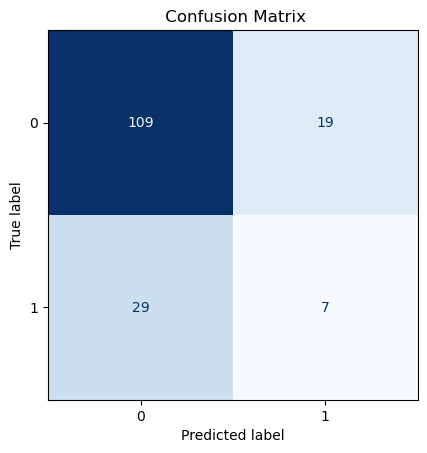

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
plt.title(" Confusion Matrix")
plt.grid(False)
plt.show()

Conclusion:
- severe overfitting with poor F1 score.

## Hyperparameter tuning

In [43]:
'''Hyperparameters for Random Forest Classifier'''

# Number of trees in random forest
rf_n_estimators = [150, 200, 250]
# Number of features to consider at every split
rf_max_features = ['sqrt', 'log2', 0.8]
# Maximum number of levels in tree
rf_max_depth = [5, 10, 20, 30]
# Minimum number of samples required to split a node
rf_min_samples_split = [2, 5, 10, 20]
# Minimum number of samples required at each leaf node
rf_min_samples_leaf = [1, 3, 5, 7, 10]
# Method of selecting samples for training each tree
rf_bootstrap = [True]
# Handle imbalance
rf_class_weight = [None] # already did upsampling/downsampling earlier

# Combined
rf_hyperparameters = {
    'classifier__n_estimators': rf_n_estimators,
    'classifier__max_features': rf_max_features,
    'classifier__max_depth': rf_max_depth,
    'classifier__min_samples_split': rf_min_samples_split,
    'classifier__min_samples_leaf': rf_min_samples_leaf,
    'classifier__bootstrap': rf_bootstrap,
    'classifier__random_state': [42]
}

In [44]:
from sklearn.model_selection import KFold
cross_val_num = 5
cv = KFold(n_splits=cross_val_num, shuffle=True, random_state=42)
print(cv)

KFold(n_splits=5, random_state=42, shuffle=True)


In [45]:
random_hyperparameter_grid = [
    rf_hyperparameters
    # gb_hyperparameters,
    # xgb_hyperparameters
]

model_list = [
    RandomForestClassifier()
    # GradientBoostingClassifier(),
    # XGBClassifier()
]

In [46]:
from sklearn.model_selection import RandomizedSearchCV

randomsearch_best_models = {}

for model,param_grid in zip(model_list, random_hyperparameter_grid):
    name = type(model).__name__

    clf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])


    random_grid = RandomizedSearchCV(
            estimator=clf,
            param_distributions=param_grid,
            n_iter=100,
            scoring='f1',
            cv=cv,
            random_state=42,
            verbose=3,
            n_jobs=1 #  non-parallel processing
        )

    random_grid.fit(X_train, y_train)

    randomsearch_best_models[name] = {
        'best_params': random_grid.best_params_,
        'best_score': random_grid.best_score_,
        'best_estimator': random_grid.best_estimator_
    }

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=0.8, classifier__min_samples_leaf=7, classifier__min_samples_split=5, classifier__n_estimators=200, classifier__random_state=42;, score=0.859 total time=   1.0s
[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=0.8, classifier__min_samples_leaf=7, classifier__min_samples_split=5, classifier__n_estimators=200, classifier__random_state=42;, score=0.827 total time=   1.0s
[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=0.8, classifier__min_samples_leaf=7, classifier__min_samples_split=5, classifier__n_estimators=200, classifier__random_state=42;, score=0.780 total time=   1.0s
[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=0.8, classifier__min_samples_leaf=7, classifier__min_samples_split=5, classifier__n_es

In [50]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report

randomsearchcv_model_results = {}

for model_name, model_data in randomsearch_best_models.items():
    best_pipeline = model_data['best_estimator']
    best_params = model_data['best_params']

    # Predict on training set
    y_train_pred = best_pipeline.predict(X_train)
    y_train_pred_proba = best_pipeline.predict_proba(X_train)[:, 1]

    accuracy = accuracy_score(y_train, y_train_pred)
    precision = precision_score(y_train, y_train_pred)
    recall = recall_score(y_train, y_train_pred)
    f1 = f1_score(y_train, y_train_pred)
    roc_auc = roc_auc_score(y_train, y_train_pred_proba)
    report = classification_report(y_train, y_train_pred)

    print(f'Train Accuracy: {accuracy}\n')
    print(f'Train Precision: {precision}\n')
    print(f'Train Test Recall: {recall}\n')
    print(f'Train F1 score: {f1}\n')
    print(f'Train roc_auc: {roc_auc}\n')
    print(f'Train report: {report}\n')
    
    # Predict on test set
    y_test_pred = best_pipeline.predict(X_test)
    y_test_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    report = classification_report(y_test, y_test_pred)

    randomsearchcv_model_results[model_name] = {
        'y_outputs':
        {'y_test': y_test,
         'y_test_pred': y_test_pred,
         'y_test_pred_proba': y_test_pred_proba},
        'metrics':
        {'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc},
        'report': report
    }
    print(f"\n=== {model_name} ===")
    pprint(best_params)
    print("\nMetrics:")
    pprint(randomsearchcv_model_results[model_name]['metrics'])
    print("\nClassification Report:", randomsearchcv_model_results[model_name]['report'])

Train Accuracy: 0.9984662576687117

Train Precision: 1.0

Train Test Recall: 0.9969325153374233

Train F1 score: 0.9984639016897081

Train roc_auc: 1.0

Train report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       326
           1       1.00      1.00      1.00       326

    accuracy                           1.00       652
   macro avg       1.00      1.00      1.00       652
weighted avg       1.00      1.00      1.00       652



=== RandomForestClassifier ===
{'classifier__bootstrap': True,
 'classifier__max_depth': 20,
 'classifier__max_features': 'log2',
 'classifier__min_samples_leaf': 3,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 250,
 'classifier__random_state': 42}

Metrics:
{'accuracy': 0.7195121951219512,
 'f1_score': 0.11538461538461539,
 'precision': 0.1875,
 'recall': 0.08333333333333333,
 'roc_auc': 0.52734375}

Classification Report:               precision    recall  f1-score   support



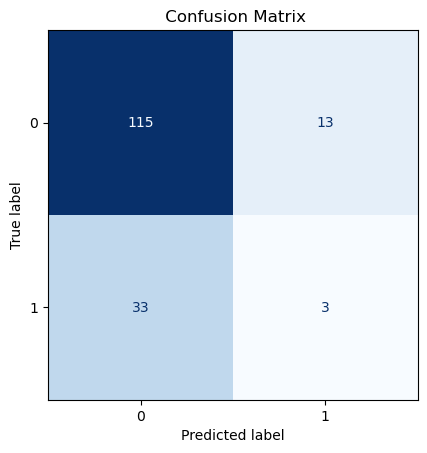

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in randomsearchcv_model_results.items():
    y_test = randomsearchcv_model_results[name]['y_outputs']['y_test']
    y_test_pred = randomsearchcv_model_results[name]['y_outputs']['y_test_pred']
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    plt.title(" Confusion Matrix")
    plt.grid(False)
    plt.show()